## IMPLEMENTATION OF RNN LSTM

In [1]:
import warnings
warnings.filterwarnings('ignore')

##### Libraries and Modules

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

# Import specific tools for time series analysis
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

##### Fixed Seed Assignment

In [3]:
seed = 812

# Setting a constant value for the seed in numpy, TensorFlow, and Keras
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

##### Reading the Dataset

In [4]:
# Read the Excel file into a DataFrame, using only the specified columns
columns = ['CLORURO DE SODIO', 'LACTATO DE SODIO', 'METAMIZOL', 'PARACETAMOL', 'PROPOFOL', 'FECHA']
time_series = pd.read_excel('/content/df_time_series (1).xlsx', usecols=columns)

# Set the 'FECHA' column as the index of the DataFrame
time_series['FECHA'] = pd.to_datetime(time_series['FECHA'])
time_series = time_series.set_index('FECHA')
time_series.index.freq = '15D'

# Display the first few rows of the DataFrame
time_series.head()

,CLORURO DE SODIO,LACTATO DE SODIO,METAMIZOL,PARACETAMOL,PROPOFOL
FECHA,,,,,
2020-01-01,8085.68,8543.5,19910.44,11596.50,34.82
2020-01-16,19.00,0.0,7.56,3.00,0.00
2020-01-31,8748.72,9012.0,19368.24,11092.85,51.00
2020-02-15,73.50,0.0,2.52,3.00,1.00
2020-03-01,8229.89,7688.0,18505.16,11746.15,20.58


##### Exploratory Analysis - Measures of Central Tendency

In [5]:
# Display descriptive statistics for the time series data
time_series.describe().round(decimals=2)

,CLORURO DE SODIO,LACTATO DE SODIO,METAMIZOL,PARACETAMOL,PROPOFOL
count,96.00,96.00,96.00,96.00,96.00
mean,3980.92,3831.88,8841.91,6112.43,22.40
std,4340.49,4221.55,9617.88,6811.60,44.43
min,2.55,0.00,0.00,0.00,0.00
25%,54.96,0.00,0.00,0.00,0.97
50%,555.55,50.75,850.86,466.50,3.10
75%,8859.38,8379.12,19409.61,13571.42,29.17
max,10835.62,10458.00,23187.20,16272.32,323.57


##### Formation of Training and Test Sets

In [6]:
"""
    Split a time series into training and testing sets.

    Parameters:
    - series (pandas Series): The time series data to split.
    - test_size (int): The size of the testing set.

    Returns:
    - training (pandas Series): The training set.
    - test (pandas Series): The testing set.
"""
def train_test_split(series, test_size=10):
    split_index = len(series) - test_size
    training, test = series[:split_index], series[split_index:]
    return training, test

In [7]:
# Split the time series data into training and testing sets using the train_test_split function
training, test = train_test_split(time_series)

# Print the sizes of the training and testing sets
print('Training set size:', training.shape)
print('Test set size:', test.shape)

Training set size: (86, 5)
Test set size: (10, 5)


##### Distribution of The Time Series

In [8]:
"""
    Plot the distribution of a time series.

    Parameters:
    - series (str): The name of the series to plot.

    Returns:
    - None
"""
def plot_distribution(series):

    plt.figure(figsize=(16, 5))
    y_label = 'Cantidad (L)' if series == 'CLORURO DE SODIO' or series == 'LACTATO DE SODIO' else 'Cantidad (G)'

    plt.plot(training[series], label='Entrenamiento', linewidth=3, linestyle='solid')
    plt.plot(test[series], label='Prueba', linewidth=3, linestyle='solid')

    plt.grid(True, linestyle='--', alpha=0.8)

    plt.legend(fontsize=13)

    plt.xlabel('Meses', fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    plt.title(f'Distribución de la serie de {series}'.upper(), fontsize=15)
    plt.legend(loc='upper left', fontsize=10)

    plt.show()

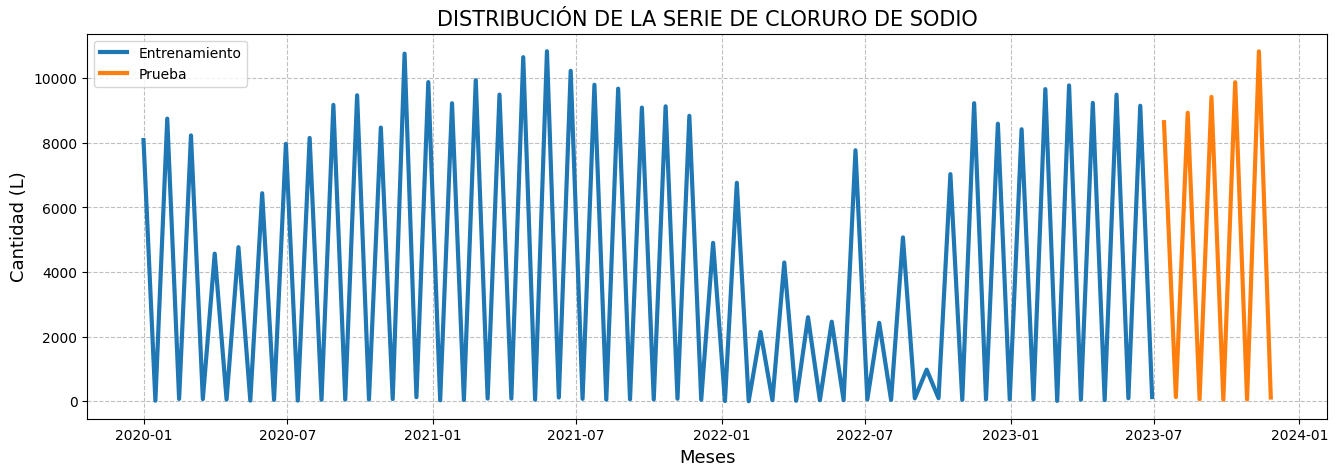

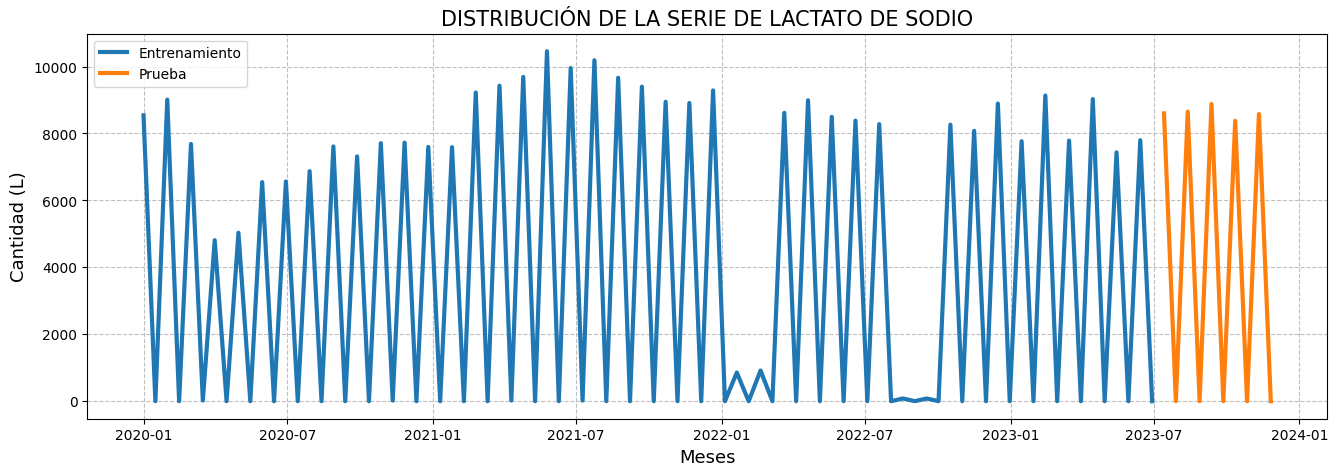

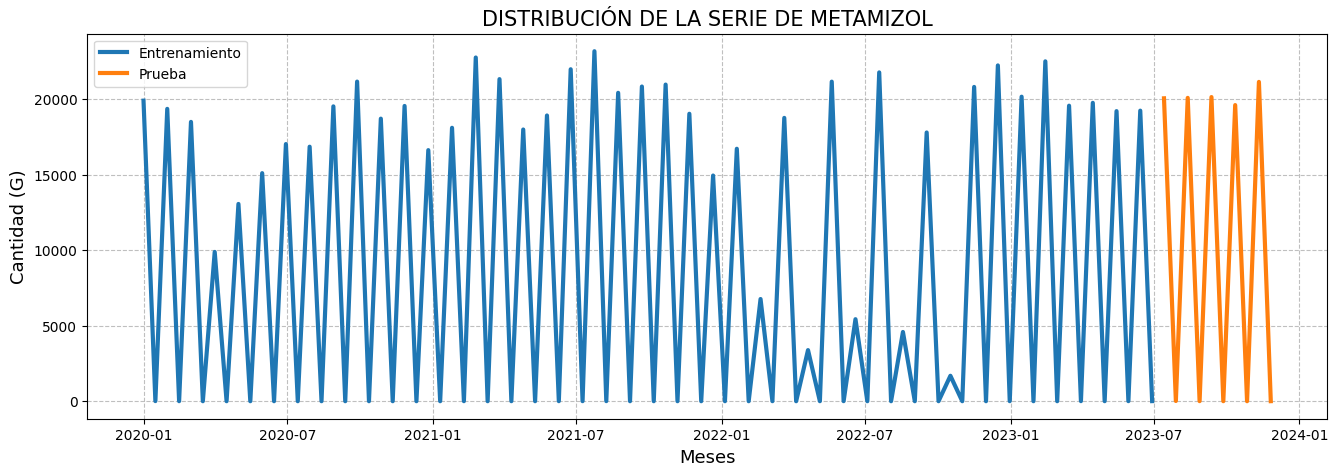

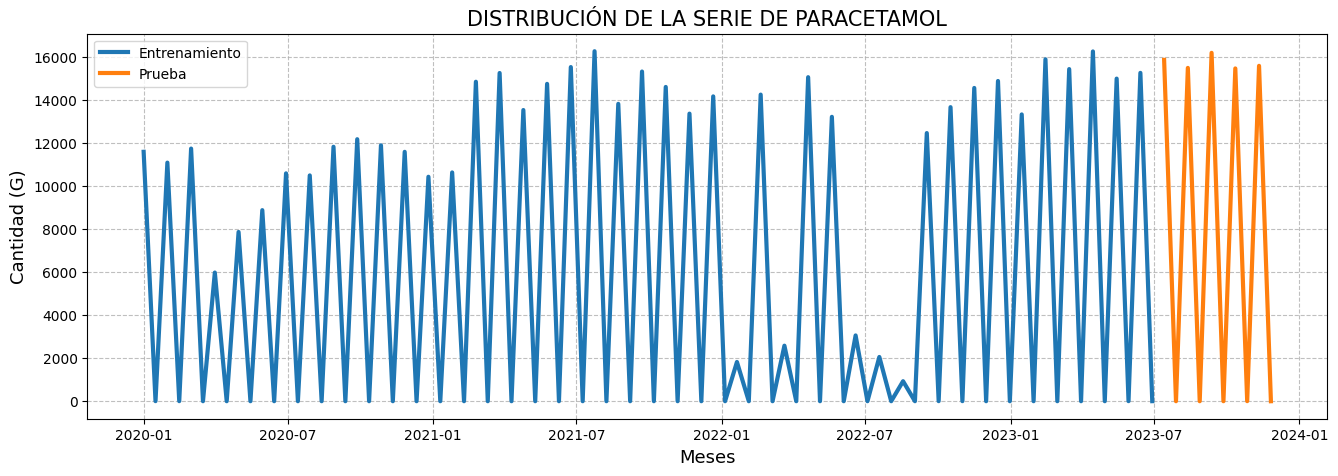

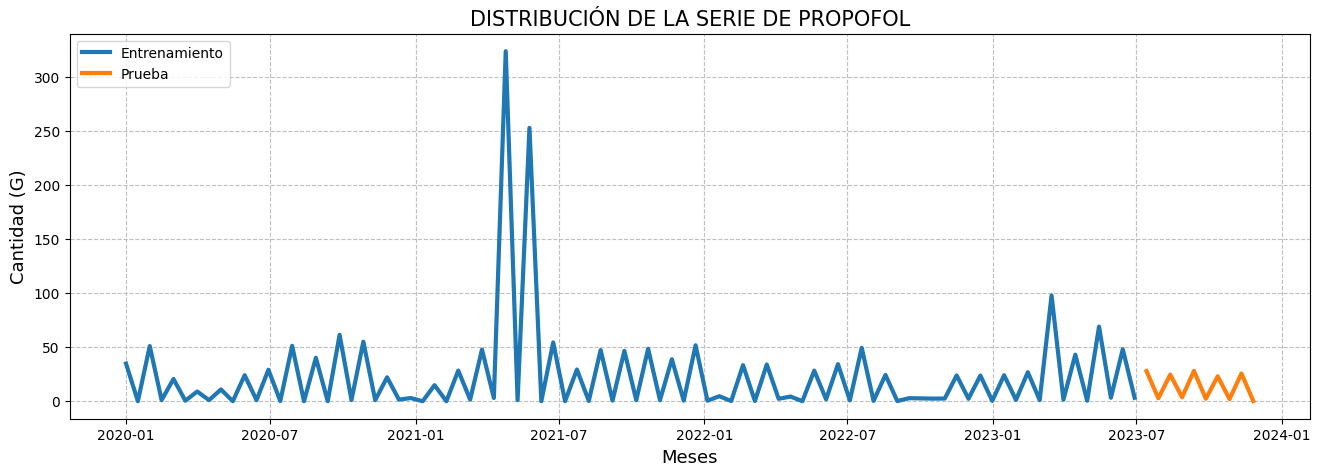

In [9]:
# Iterator to graph the distribution of all series
for series in time_series:
    plot_distribution(series)

##### Implementation of The RNN LSTM Model

In [10]:
# List of dictionaries specifying series name and corresponding RNN LSTM model n_inputs
config_list =[
    {'series': 'CLORURO DE SODIO', 'n_input': 6},
    {'series': 'LACTATO DE SODIO', 'n_input': 11},
    {'series': 'METAMIZOL', 'n_input': 3},
    {'series': 'PARACETAMOL', 'n_input': 7},
    {'series': 'PROPOFOL', 'n_input': 4}
]

In [11]:
# Dictionary to store trained models
trained_models = {}

# Iterate over each configuration in the list
for params in config_list:

    # Extract series name and input shape from the configuration
    series = params['series']
    n_input = params['n_input']
    n_features = 1

    # Define the LSTM model architecture
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Load pre-trained weights
    model.load_weights(f'/content/{series}.h5')

    # Store the trained model in the dictionary
    trained_models[series] = model

In [12]:
"""
    Scale the training data for a given series using MinMaxScaler.

    Parameters:
    - series (str): The name of the series.

    Returns:
    - scaler (MinMaxScaler): The scaler object fitted to the training data.
    - scaled_train (numpy.ndarray): The scaled training data for the specified series.
"""
def get_scaled_train(series, training_df):
    scaler = MinMaxScaler()
    train = training_df[[series]]
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    return scaler, scaled_train

In [13]:
"""
    Generate predictions for a given series using a trained model.

    Parameters:
    - series (str): The name of the series.
    - model_fit: The fitted model object.
    - scaler: The scaler object fitted to the training data.
    - scaled_train (numpy.ndarray): The scaled training data for the specified series.

    Returns:
    - forecast (dict): A dictionary containing the forecasted values for the specified series.
"""
def get_predictions(series, model_fit, scaler, scaled_train):

    # Initialize lists to store predictions and forecasted values
    predictions = []
    forecast = {}

    # Get the input and output shapes of the model
    _n_input = model_fit.input_shape[1]
    _n_features = model_fit.output_shape[1]

    # Get the last batch of scaled training data
    first_eval_batch = scaled_train[-_n_input:]
    current_batch = first_eval_batch.reshape((1, _n_input, _n_features))

    # Generate predictions iteratively for each time step in the test set
    for i in range(len(test)):
        current_pred = model_fit.predict(current_batch, verbose=0)[0]
        predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    # Inverse transform the scaled predictions to obtain forecasted values
    forecast[series] = scaler.inverse_transform(predictions)

    # Return the forecasted values
    return forecast

In [14]:
!pip install googletrans==4.0.0-rc1

In [25]:
from googletrans import Translator

translator = Translator()
"""
    Plot the cross-validation results for a given series.

    Parameters:
    - series (str): The name of the series.
    - forecast_values (array-like): The forecasted values for the series.

    Returns:
    - None
"""
def plot_cross_validation(series, forecast_values):

    forecasting_series = pd.Series(forecast_values.flatten(), test[series].index)
    y_label = 'Quantity (L)' if series == 'CLORURO DE SODIO' or series == 'LACTATO DE SODIO' else 'Quantity (G)'

    plt.figure(figsize=(16, 5))

    plt.plot(training[series], label='Training', linewidth=3, linestyle='solid')
    plt.plot(test[series], label='Test', linewidth=3, linestyle='solid')
    plt.plot(forecasting_series, label='Forecasting', linewidth=2, linestyle='dashed')

    plt.grid(True, linestyle='--', alpha=1)

    plt.legend(fontsize=13)

    plt.xlabel('Months', fontsize=13)
    plt.ylabel(y_label, fontsize=13)
    serieName = translator.translate(series,src='es', dest='en').text
    plt.title(f'Forecasting {serieName}'.upper(), fontsize=15)
    plt.legend(loc='upper left', fontsize=10)
    plt.savefig(f'fig_5_{serieName}.png')
    plt.show()

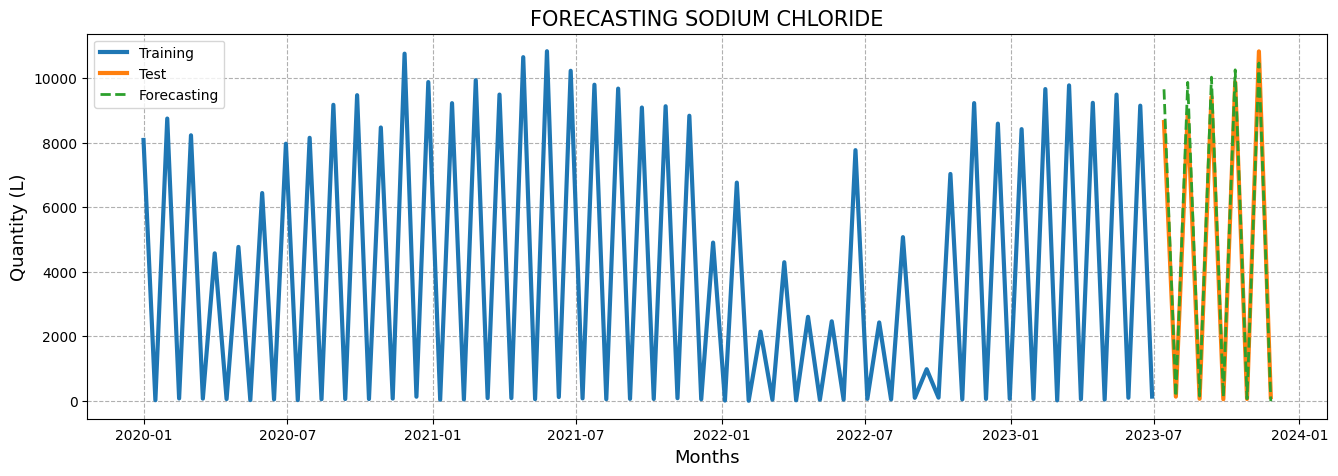

CLORURO DE SODIO,REAL,FORECAST
FECHA,,
2023-07-14,8639.62,9655.229616
2023-07-29,129.90,136.476599
2023-08-13,8929.96,9870.030544
2023-08-28,63.15,148.581198
2023-09-12,9420.57,10031.535287
2023-09-27,48.90,122.497570
2023-10-12,9875.78,10258.736909
2023-10-27,57.80,65.802858
2023-11-11,10830.82,10468.805492


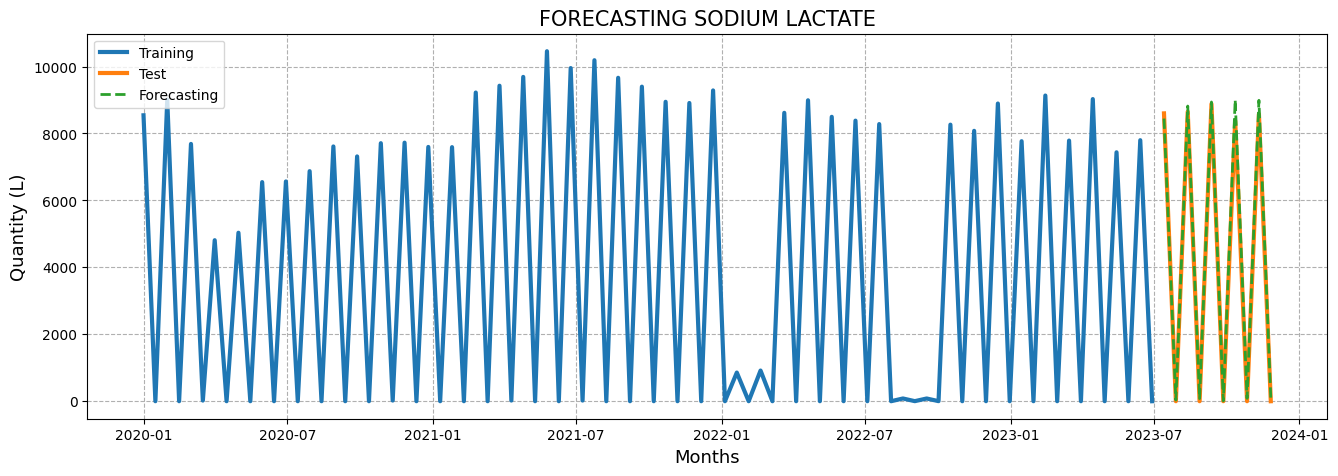

LACTATO DE SODIO,REAL,FORECAST
FECHA,,
2023-07-14,8600.5,8445.445305
2023-07-29,0.0,35.586476
2023-08-13,8651.0,8819.574082
2023-08-28,0.0,79.064738
2023-09-12,8882.5,8941.265437
2023-09-27,0.5,10.196528
2023-10-12,8377.5,9002.804585
2023-10-27,0.0,86.753158
2023-11-11,8581.0,8991.240905


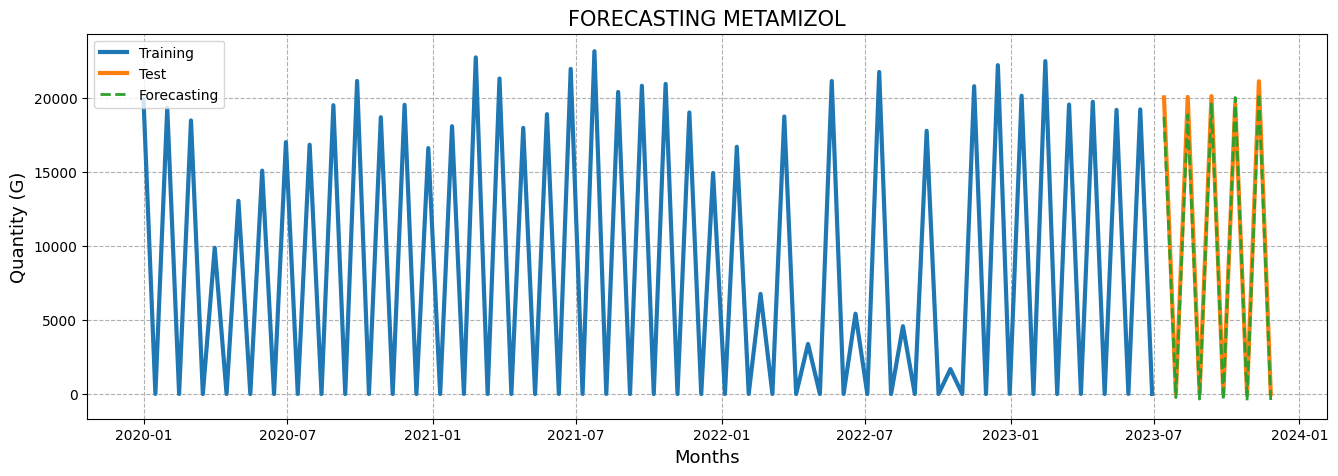

METAMIZOL,REAL,FORECAST
FECHA,,
2023-07-14,20066.80,18735.464180
2023-07-29,16.00,-238.026459
2023-08-13,20095.76,18885.666985
2023-08-28,5.00,-343.794498
2023-09-12,20149.52,19619.325037
2023-09-27,2.00,-405.831068
2023-10-12,19618.72,20056.965537
2023-10-27,0.00,-453.633235
2023-11-11,21154.56,20329.085807


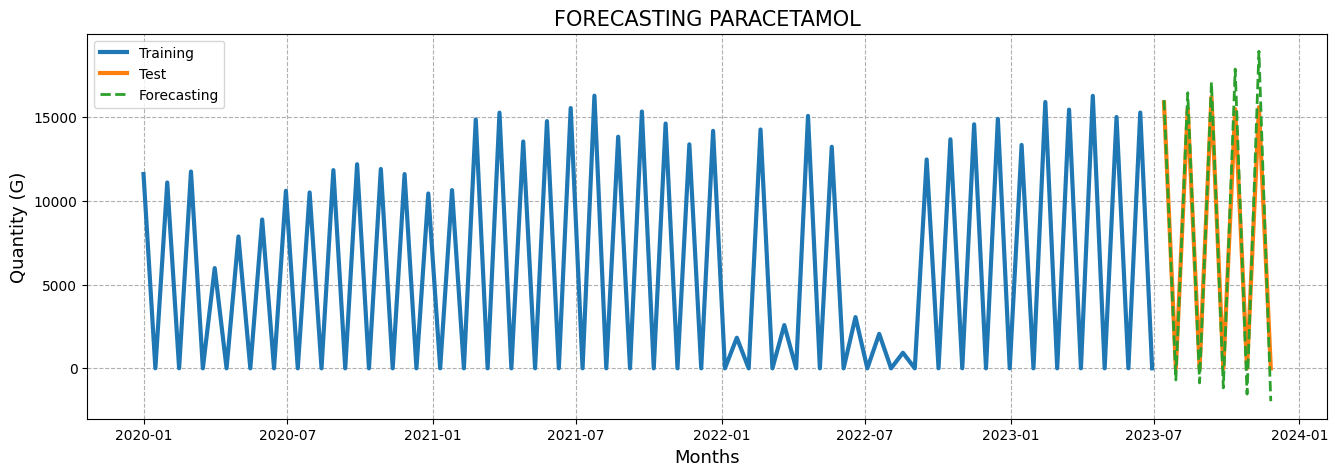

PARACETAMOL,REAL,FORECAST
FECHA,,
2023-07-14,15869.500,16012.408580
2023-07-29,0.000,-693.423491
2023-08-13,15496.500,16444.997392
2023-08-28,0.000,-870.595642
2023-09-12,16197.000,17084.221800
2023-09-27,0.000,-1170.564094
2023-10-12,15472.000,17862.228140
2023-10-27,3.000,-1538.726163
2023-11-11,15592.875,18926.599271


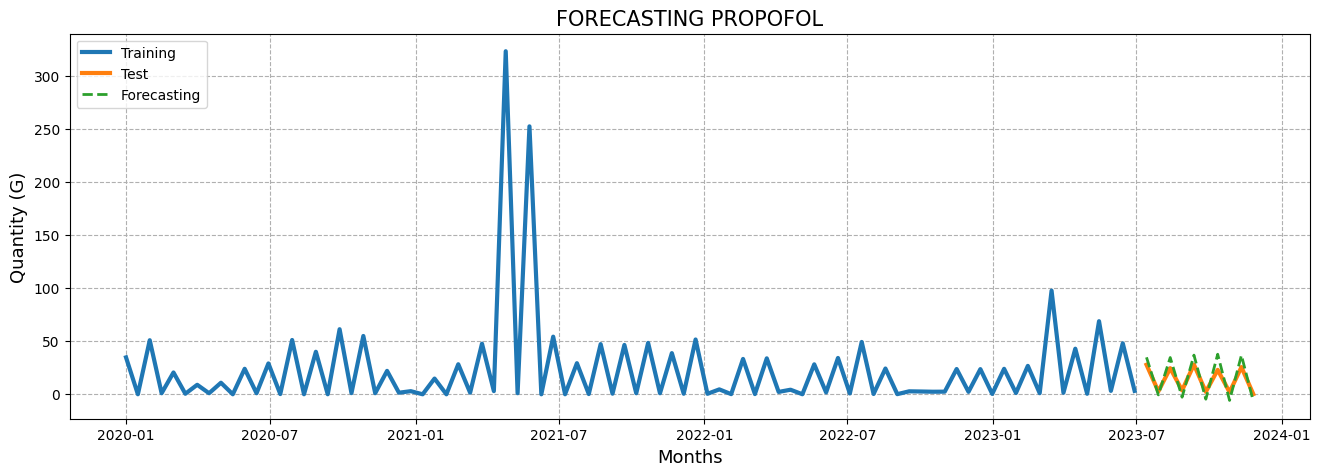

PROPOFOL,REAL,FORECAST
FECHA,,
2023-07-14,27.87,34.856147
2023-07-29,2.74,-0.548117
2023-08-13,24.61,34.665232
2023-08-28,3.68,-2.724259
2023-09-12,28.01,36.935577
2023-09-27,2.29,-4.597914
2023-10-12,23.02,37.770757
2023-10-27,1.98,-5.772168
2023-11-11,25.67,36.772866


In [26]:
# List to store cross-validation metrics
metrics = []

# Iterate over each trained ARIMA model
for series, model_fit in trained_models.items():

    # Make forecasts using the fitted model
    scaler, scaled_train = get_scaled_train(series, training)
    forecast = get_predictions(series, model_fit, scaler, scaled_train)

    # Calculate evaluation metrics
    mae = mean_absolute_error(test[series], forecast[series])
    mse = mean_squared_error(test[series], forecast[series])
    rmse = np.sqrt(mse)

    # Creating a dataframe with forecasted values
    series_forecast = pd.DataFrame({
        'REAL': test[series],
        'FORECAST': forecast[series].flatten()
    }, index=test.index)

    # Assigning a name to the index of the columns
    series_forecast.columns.name = series

    # Store the metrics in the list
    metrics.append({
        'SERIES': series,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

    # Show the results
    plot_cross_validation(series, forecast[series])
    display(series_forecast)

##### Performance Metrics for The Test Dataset

In [17]:
pd.DataFrame(metrics).round(decimals=2)

,SERIES,MAE,MSE,RMSE
0,CLORURO DE SODIO,361.54,259594.11,509.50
1,LACTATO DE SODIO,172.66,63987.68,252.96
2,METAMIZOL,629.27,519277.18,720.61
3,PARACETAMOL,1394.25,2737573.79,1654.56
4,PROPOFOL,8.29,77.47,8.80


##### Future Forecasts

In [18]:
"""
    Plot the future forecast for a given series.

    Parameters:
    - series (str): The name of the series.
    - forecast_values (array-like): Forecasted values for the future.

    Returns:
    - None
"""
def plot_future_forecast(series, forecasting_series):

    training_series = time_series[series][:-10]
    test_series  = time_series[series][-10:]

    y_label = 'Cantidad (L)' if series == 'CLORURO DE SODIO' or series == 'LACTATO DE SODIO' else 'Cantidad (G)'

    plt.figure(figsize=(16,5))
    plt.plot(training_series, label='Entrenamiento', linewidth=3, linestyle='solid')
    plt.plot(test_series, label='Prueba', linewidth=3, linestyle='dashed')
    plt.plot(forecasting_series, label='Pronósticos', linewidth=3, linestyle='dashed')

    plt.grid(True, linestyle='--', alpha=1)
    plt.legend(fontsize=13)

    plt.xlabel('Meses', fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    plt.title(f'Pronósticos para los siguientes 5 meses - {series}'.upper(), fontsize=15)
    plt.legend(loc='upper left', fontsize=10)

    plt.show()

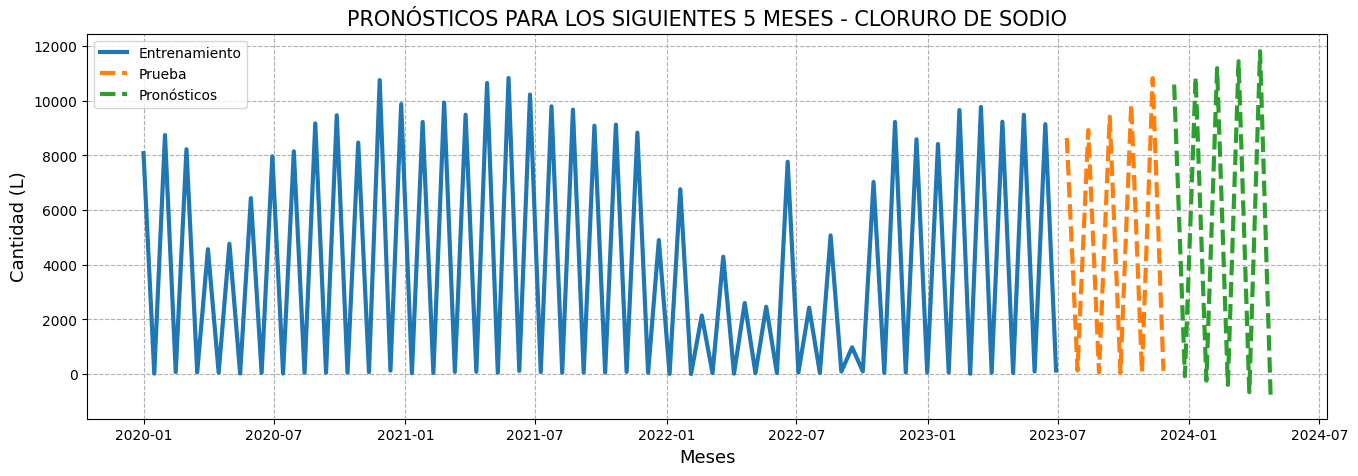

CLORURO DE SODIO,REAL,FORECAST
2023-12-11,Unknown,10597.400778
2023-12-26,Unknown,-76.246825
2024-01-10,Unknown,10869.055704
2024-01-25,Unknown,-239.035303
2024-02-09,Unknown,11195.151643
2024-02-24,Unknown,-395.587760
2024-03-10,Unknown,11448.365987
2024-03-25,Unknown,-660.844917
2024-04-09,Unknown,11815.456209
2024-04-24,Unknown,-992.402561


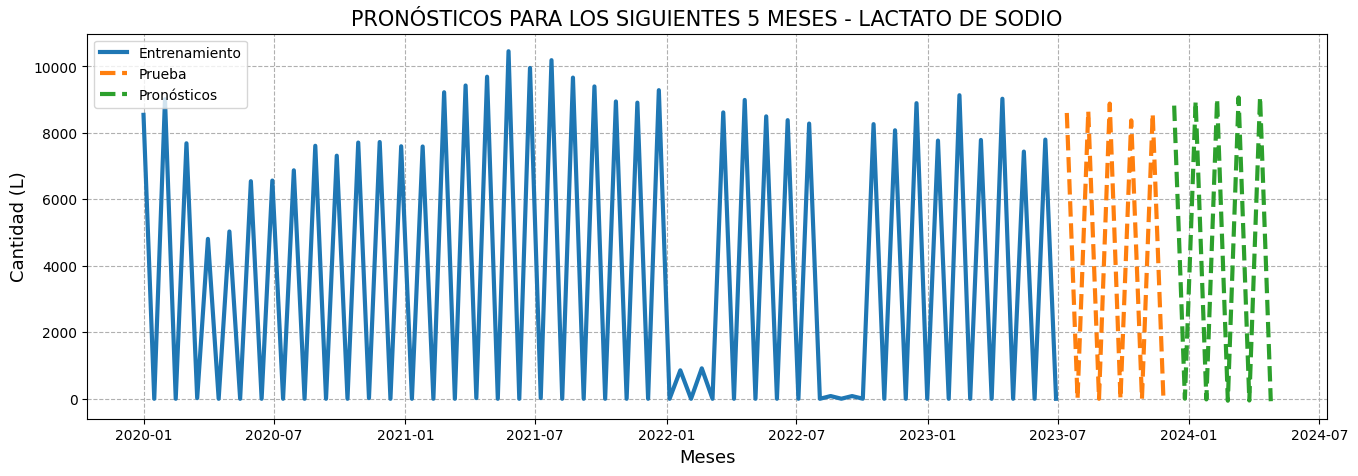

LACTATO DE SODIO,REAL,FORECAST
2023-12-11,Unknown,8821.562554
2023-12-26,Unknown,3.395206
2024-01-10,Unknown,8956.092953
2024-01-25,Unknown,-18.899364
2024-02-09,Unknown,9023.189849
2024-02-24,Unknown,-57.864216
2024-03-10,Unknown,9067.116374
2024-03-25,Unknown,-51.531573
2024-04-09,Unknown,9085.108615
2024-04-24,Unknown,-73.300663


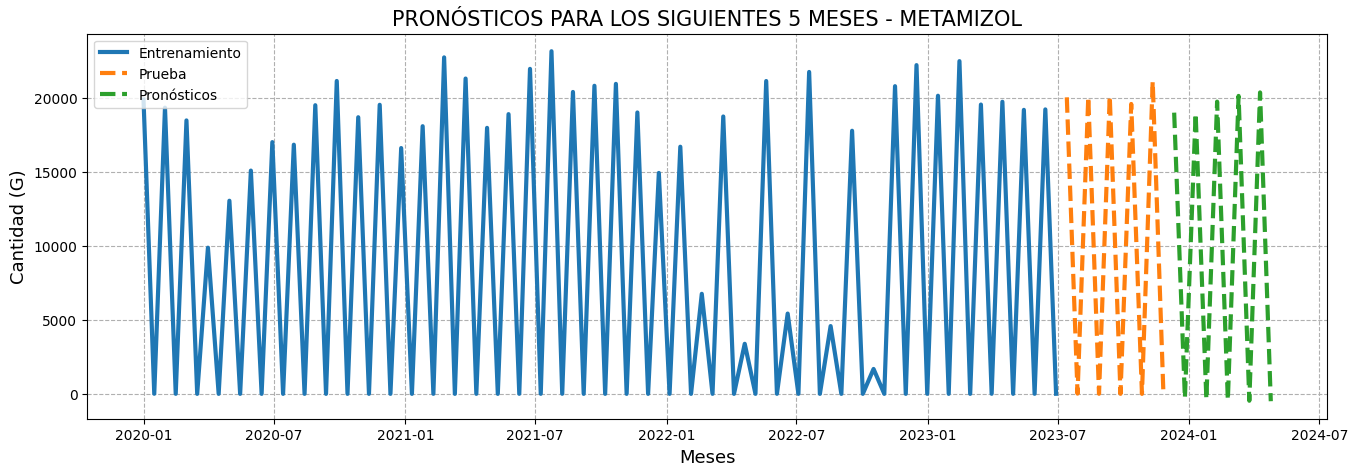

METAMIZOL,REAL,FORECAST
2023-12-11,Unknown,19030.684282
2023-12-26,Unknown,-284.538382
2024-01-10,Unknown,18982.334126
2024-01-25,Unknown,-370.018832
2024-02-09,Unknown,19775.603399
2024-02-24,Unknown,-421.970649
2024-03-10,Unknown,20163.206242
2024-03-25,Unknown,-465.748416
2024-04-09,Unknown,20398.733582
2024-04-24,Unknown,-497.556119


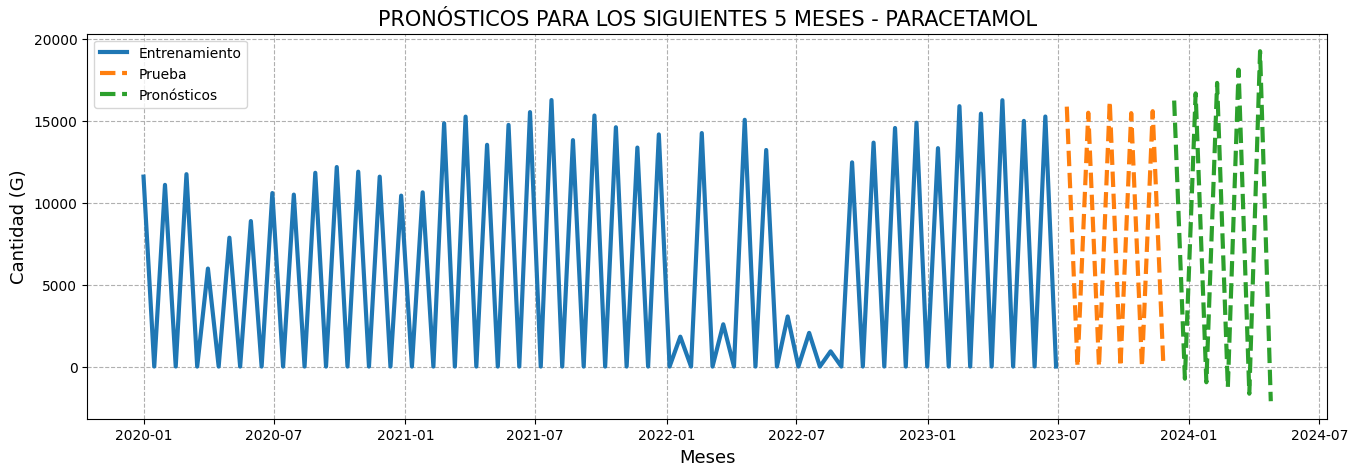

PARACETAMOL,REAL,FORECAST
2023-12-11,Unknown,16240.666293
2023-12-26,Unknown,-738.601599
2024-01-10,Unknown,16676.818541
2024-01-25,Unknown,-958.707736
2024-02-09,Unknown,17318.496812
2024-02-24,Unknown,-1267.222517
2024-03-10,Unknown,18127.390783
2024-03-25,Unknown,-1656.376749
2024-04-09,Unknown,19252.447002
2024-04-24,Unknown,-2115.580635


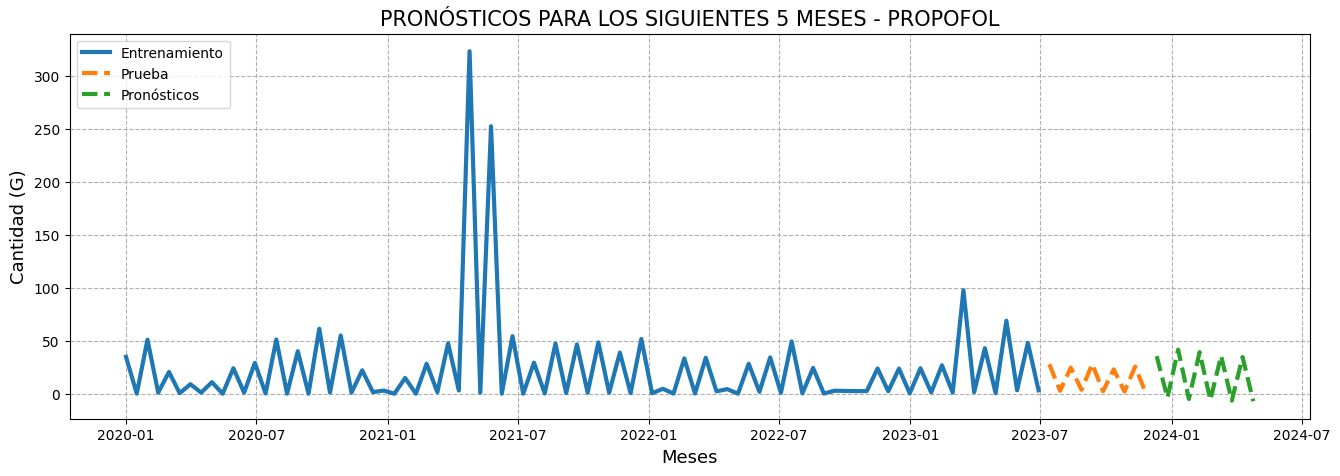

PROPOFOL,REAL,FORECAST
2023-12-11,Unknown,35.485724
2023-12-26,Unknown,-3.800817
2024-01-10,Unknown,41.597862
2024-01-25,Unknown,-5.058416
2024-02-09,Unknown,39.279498
2024-02-24,Unknown,-6.006140
2024-03-10,Unknown,35.873877
2024-03-25,Unknown,-6.573020
2024-04-09,Unknown,34.699473
2024-04-24,Unknown,-7.102804


In [19]:
# Iterate over each trained ARIMA model
for series, model_fit in trained_models.items():

    # Make forecasts using the fitted model
    scaler, scaled_train = get_scaled_train(series, time_series)
    forecast = get_predictions(series, model_fit, scaler, scaled_train)

    last_test_index = test.index[-1] + pd.Timedelta(days=15)
    forecast_index = pd.date_range(start=last_test_index, periods=len(forecast[series]), freq='15D')

    forecasting_series = pd.Series(forecast[series].flatten(), index=forecast_index)

    # Creating a dataframe with forecasted values
    series_forecast = pd.DataFrame({
        'REAL': 'Unknown',
        'FORECAST': forecast[series].flatten()
    }, index=forecast_index)

    # Assigning a name to the index of the columns
    series_forecast.columns.name = series

    # Show the results
    plot_future_forecast(series, forecasting_series)
    display(series_forecast)